In [1]:
import psycopg2
from postgis.psycopg import register
import project_path
from db_importer.settings import *
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

class DatabaseConnection(object):
    def __enter__(self):
        self.conn = psycopg2.connect(f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}' port='{DB_PORT}'")
        self.conn.autocommit = True

        register(self.conn)
        self.cur = self.conn.cursor()

        return self.cur

    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_tb is None:
            self.conn.commit()
            self.cur.close()
            self.conn.close()
        else:
            self.conn.rollback()
            self.cur.close()
            self.conn.close()


36.13514033509662


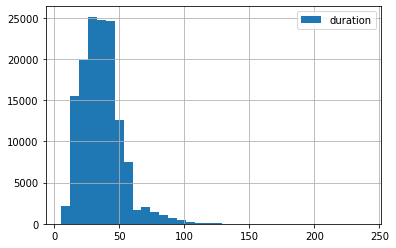

In [2]:
# Histogram of decel durations

with DatabaseConnection() as cur:
    cur.execute("""select seg_id, sum(duration) from accels where type='d' group by seg_id""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['seg_id', 'duration'])
    df.duration.hist(bins=34, legend=True)
    plt.savefig("images/decel_duration.png", bbox_inches='tight')
print(df.duration.mean())
    


152.73180555253546


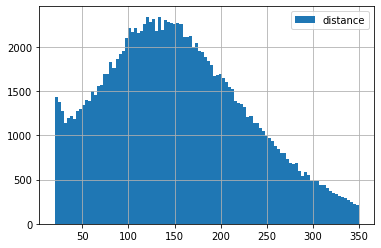

In [3]:
# Histogram of decel distance

with DatabaseConnection() as cur:
    cur.execute("""select seg_id, sum(dist) from accels where type='d' group by seg_id having sum(dist)<350 and sum(dist)>10""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['seg_id', 'distance'])
    df.distance.hist(bins=100, legend=True)
    plt.savefig("images/decel_distance.png", bbox_inches='tight')
print(df.distance.mean())

-0.7545925075090733


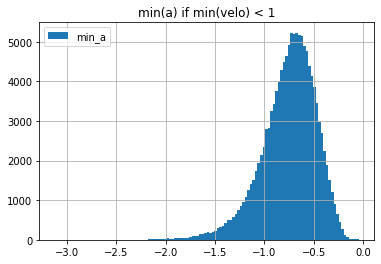

In [4]:
with DatabaseConnection() as cur:
    cur.execute("""select seg_id, min(accel), sum(duration), sum(dist) from accels where type='d' group by seg_id having sum(dist)<350 and min(velo) < 1""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['seg_id', 'min_a', 'duration', 'distance'])
    print(df.min_a.mean())
    df.min_a.hist(bins=120, legend=True)
    plt.title('min(a) if min(velo) < 1')
    plt.savefig("images/decel_min_a_1.png", bbox_inches='tight')


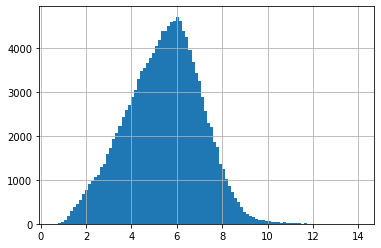

In [5]:
# Histogram of Delta velo

with DatabaseConnection() as cur:
    cur.execute("""select seg_id, max(velo) - min(velo) from accels where type = 'd' group by seg_id having sum(dist)>20""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['seg_id', 'delta_velo'])
    df.delta_velo.hist(bins=100)



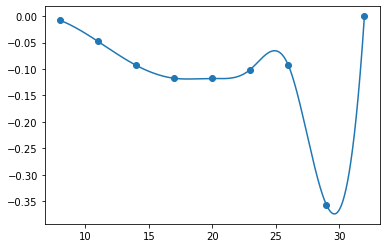

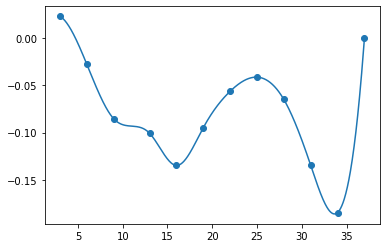

In [6]:
# Plot of representative decel processes 

from scipy.interpolate import make_interp_spline, BSpline


def plot_accels(x, one_plot):
    
    last_entry = pd.DataFrame(
                {"a":[0],
                 "duration":[3],
                 "seg_id":[42],
                 "velo": [0]})
    
    x = x.append(last_entry)
    
    x['cum_duration'] = x.duration.cumsum()

    x = x[~x.a.isnull()]
    
    xnew = np.linspace(x.cum_duration.min(), x.cum_duration.max(), 1000) 
    
    spl_a = make_interp_spline(x.cum_duration, x.a)  # type: BSpline
    #spl_v = make_interp_spline(x.cum_duration, x.velo)  # type: BSpline
    smooth_a = spl_a(xnew)
    #smooth_v = spl_v(xnew)

    plt.plot(xnew, smooth_a)
    #plt.plot(xnew, smooth_v)
    plt.scatter(x.cum_duration, x.a)
    #plt.scatter(x.cum_duration, x.velo)
    plt.show()
    
with DatabaseConnection() as cur:
    cur.execute("""select seg_id, accel, duration, velo from accels where type = 'd' Limit 20""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['seg_id','a', 'duration', 'velo'])
    df.groupby('seg_id', as_index=False).apply(lambda x: plot_accels(x, False))

/home/kons/GIT/ma/ma_env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


26.863797277021163 16.200805355263036 -6.597314563475979 6.60604716231369
-0.3718416244062057


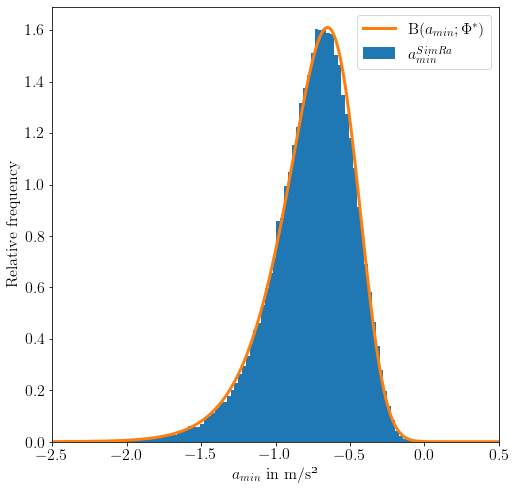

In [9]:
import scipy.stats
from matplotlib import rc

with DatabaseConnection() as cur:
    cur.execute("""select seg_id, min(accel), sum(duration), sum(dist) from accels where type='d' group by seg_id having sum(dist)<350 and min(velo) < 1""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['seg_id', 'min_a', 'duration', 'distance'])

    plt.figure(figsize=(8,8))
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
    rc('text', usetex=True)
    plt.hist(df.min_a, bins=120, density=True, label=r'$a_{min}^{SimRa}$')

    c,d,loc,scale= scipy.stats.burr12.fit(df.min_a)
    x = np.linspace(-2.5, 0.5, 500)
    y = scipy.stats.burr12.pdf(x, c,d,loc,scale)

    plt.plot(x, y, linewidth=3, label='B(' + r'$a_{min}; \Phi^*$' + ')')
    plt.xlim(-2.5, 0.5)
    plt.xlabel(r'$a_{min}$ in m/s²')
    plt.ylabel('Relative frequency')
    plt.legend()
    plt.savefig('images/max_deceleration_dist_fit',dpi=300, bbox_inches='tight')

print(c, d, loc, scale)
print(scipy.stats.burr12(c,d,loc,scale).ppf(0.95))

In [ ]:
# Find best distribution fit

list_of_dists = ['powernorm','norm','exponnorm','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','frechet_r','frechet_l','genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']
results=[]
for i in list_of_dists:
    dist = getattr(scipy.stats, i)
    param = dist.fit(df.min_a)
    a = scipy.stats.kstest(df.min_a, i, args=param)
    results.append((i,a[0],a[1]))
    
    
results.sort(key=lambda x:float(x[2]), reverse=True)
for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))